# Titanic dataset

In this notebook we present a complete solution of Kaggle's titanic competition. The notebook is organised as followed:
* EDA
* Feature engineering
* Model selection: we train and tune hyperparameters of 4 classifiers. This is done with an automated procedure
* Stacking & xgboost: we use stacking in an attempt to improve our LB score and use xgboost as 2nd level classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [508]:
#this is just for the final presentation, to make the notebook look nicer
import warnings
warnings.filterwarnings("ignore")

## EDA

Let's start by reading in raw train and test data.

In [492]:
raw_train = pd.read_csv("train.csv")
raw_test = pd.read_csv("test.csv")

Let's peek at the the first 5 rows of our raw training set.

In [3]:
raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The same for the raw test set.

In [4]:
raw_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Let's inspect what kind of data is stored in our training data frame.

In [5]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We see there are some missing values in Age and Embarked columns and 78% of Cabin column is missing.

Let's convert Pclass feature to type object, as it really is a categorical feature.

In [6]:
raw_train['Pclass'] = raw_train['Pclass'].astype('object')
raw_test['Pclass'] = raw_test['Pclass'].astype('object')

Inspecting missing values for the test set:

In [7]:
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null object
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 36.0+ KB


In [8]:
raw_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Similarly to our training set, we see a lot of missing Cabins, some missing Ages but also 1 missing fare and no missing Embarked.

Let's look at basic summary statistics of our training set.

In [9]:
raw_train.iloc[:,1:].describe() #.iloc[:,1:] to exclude PassengerId

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


We note the following: 
* Around 38% of passengers survived
* most passengers have travelled alone,
* mean and median age are close, around 28-29 years; relatively few elderly passengers,
* 50% of fares line in the interval (7.9, 31), but maximum fare is 512.

Let's now examine basic summary statistics of categorica features.

In [10]:
raw_train.describe(include=[np.object])

,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,204,889
unique,3,891,2,681,147,3
top,3,"Gronnestad, Mr. Daniel Danielsen",male,347082,G6,S
freq,491,1,577,7,4,644


We observer the following:
* nearly 65% of passengers were male,
* all names are unique,
* Surprisingly (or not?), not all tickets are unique,
* some Cabin were shared
* 72% of passengers embarked in Southampton
* unsurprisingly, most (over half) passengers were 3rd class

Let's use pivot tables and visualisation to inspect how various features correlate with the chance of survival.

First let's examine the overall survival rate by sex.

In [11]:
raw_train.groupby('Sex')[['Survived']].mean()

,Survived
Sex,
female,0.742038
male,0.188908


Let's compare then number of male and female passengers in each class.

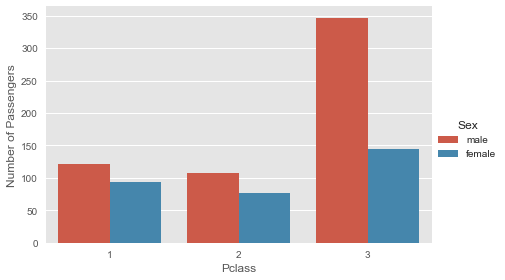

In [12]:
with plt.style.context('ggplot'):
    g = sns.factorplot("Pclass", data=raw_train, aspect=1.5, kind='count',hue='Sex')
    g.set_ylabels('Number of Passengers')

Now let's examine the survival rate by class and sex:

In [13]:
df = raw_train.pivot_table('Survived', index = 'Sex', columns = 'Pclass', margins= True)
df

Pclass,1,2,3,All
Sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


We see that nearly all first class women survived, with only a 4% survival rate drop between classed 1 and 2. For men, survival rate was also the highest among the first class passengers, but it halved for the second class male passengers as compared to first class. There was no much difference between first and second class male passengers, as opposed to female passengers, where we observed survival rate to drop by a factor of a half.

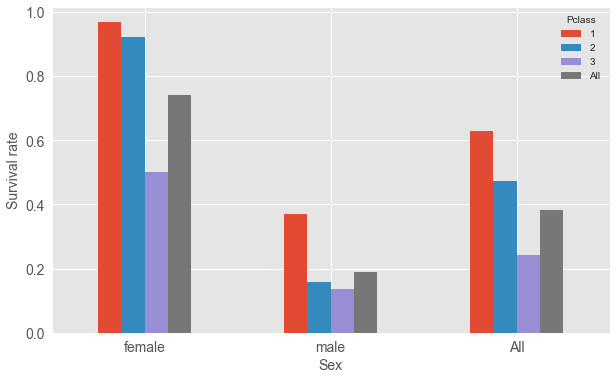

In [14]:
with plt.style.context('ggplot'):
    df.plot(df.index, df.columns,kind = 'bar', figsize=(10,6), fontsize = 14)
    plt.ylabel('Survival rate', fontsize = 14)
    plt.xlabel('Sex', fontsize = 14)
    plt.xticks(rotation = 0)

We now understand the influence of Pclass on survival rate and how it differes between genders. Let's examine the relationships between age or fare and survival rate.

Firstly, let's bin the ages into four quantiles and examin survival rates by age group, sex and Pclass.

In [15]:
ages = pd.qcut(raw_train['Age'],4)
df = raw_train.pivot_table('Survived', index = ['Sex', 'Pclass'], columns = ages)
df

Age            [0.42, 20.125]  (20.125, 28]  (28, 38]  (38, 80]
Sex    Pclass                                                  
female 1             0.928571      0.933333  1.000000  0.968750
       2             1.000000      0.863636  0.950000  0.875000
       3             0.510638      0.538462  0.470588  0.083333
male   1             0.571429      0.562500  0.500000  0.277778
       2             0.526316      0.000000  0.096774  0.083333
       3             0.197368      0.126582  0.169492  0.076923

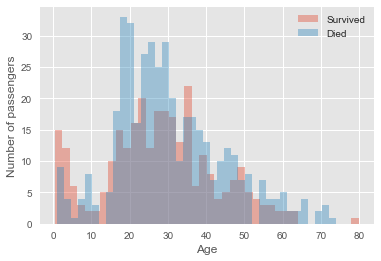

In [16]:
kwargs = dict(histtype='stepfilled', alpha=0.4, normed=False, bins=40)

with plt.style.context('ggplot'):
    plt.hist(raw_train.query('Survived == 1')['Age'].dropna(), **kwargs, label = 'Survived')
    plt.hist(raw_train.query('Survived == 0')['Age'].dropna(), **kwargs, label = 'Died')
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of passengers");

We note the following:
* Children were more likely to survive than adults
* The eldest passengers survived
* Highest mortality was in the age group 20-30, perhaps due to male 3rd class passengers? Let's examine that!

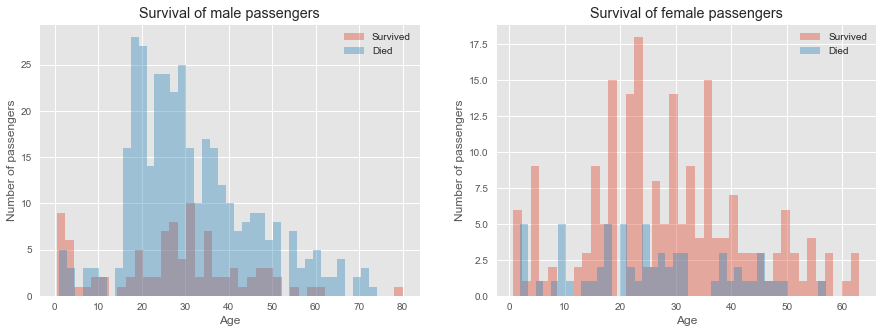

In [17]:
with plt.style.context('ggplot'):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)
    plt.hist(raw_train.query('Survived == 1 & Sex == "male"')['Age'].dropna(), **kwargs, label = 'Survived')
    plt.hist(raw_train.query('Survived == 0 & Sex == "male"')['Age'].dropna(), **kwargs, label = 'Died')
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of passengers")
    plt.title('Survival of male passengers');
    
    plt.subplot(1,2,2)
    plt.hist(raw_train.query('Survived == 1 & Sex == "female"')['Age'].dropna(), **kwargs, label = 'Survived')
    plt.hist(raw_train.query('Survived == 0 & Sex == "female"')['Age'].dropna(), **kwargs, label = 'Died')
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of passengers")
    plt.title('Survival of female passengers');

We observe that:
* vast majority of males around 20 have died. 
* Children survival seems to be independent of their gender
* The peak in femal survival is just over 20
* The peak in male survival is just over 30

Repeat the same exercise, this time differentiating by Pclass.

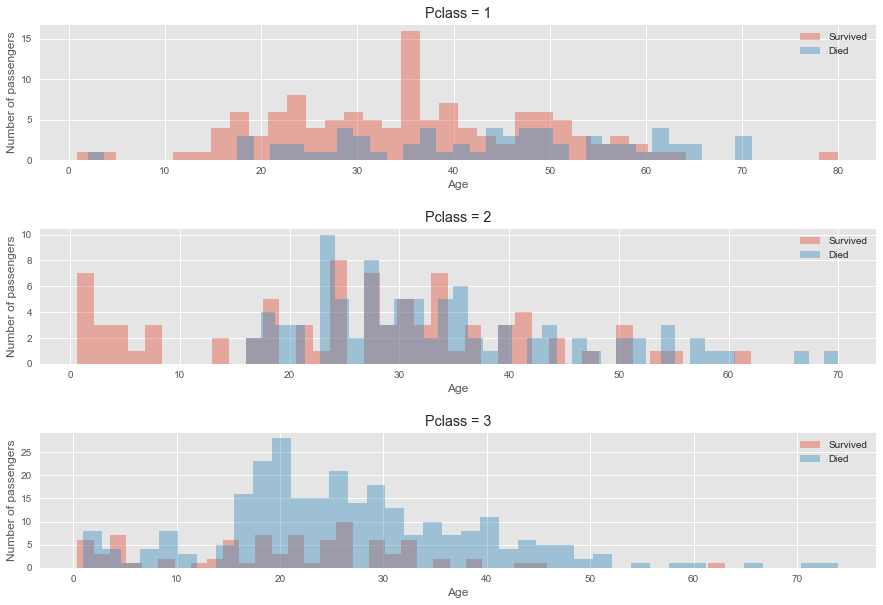

In [18]:
with plt.style.context('ggplot'):
    
    plt.figure(figsize = (15,10))
    
    plt.subplot(3,1,1)
    plt.hist(raw_train.query('Survived == 1 & Pclass == 1')['Age'].dropna(), **kwargs, label = 'Survived')
    plt.hist(raw_train.query('Survived == 0 & Pclass == 1')['Age'].dropna(), **kwargs, label = 'Died')
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of passengers")
    plt.title('Pclass = 1');
    
    plt.subplot(3,1,2)
    plt.hist(raw_train.query('Survived == 1 & Pclass == 2')['Age'].dropna(), **kwargs, label = 'Survived')
    plt.hist(raw_train.query('Survived == 0 & Pclass == 2')['Age'].dropna(), **kwargs, label = 'Died')
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of passengers")
    plt.title('Pclass = 2');
    
    plt.subplot(3,1,3)
    plt.hist(raw_train.query('Survived == 1 & Pclass == 3')['Age'].dropna(), **kwargs, label = 'Survived')
    plt.hist(raw_train.query('Survived == 0 & Pclass == 3')['Age'].dropna(), **kwargs, label = 'Died')
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of passengers")
    plt.title('Pclass = 3');
    
    plt.subplots_adjust(hspace = 0.5)

The plot above clearly show the differences between survival rates in each class. Even mortality rate for children has significanlty increased for Pclass = 3.

Let's examine the effect of port of embarkment on survival.

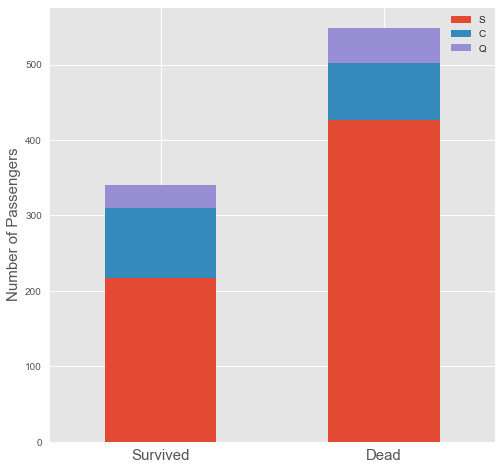

In [19]:
with plt.style.context('ggplot'):
    
    survived = raw_train.query('Survived ==1')['Embarked'].value_counts()
    died = raw_train.query('Survived == 0')['Embarked'].value_counts()
    df = pd.DataFrame([survived,died])
    df.index = ['Survived','Dead']
    df.plot(kind='bar', stacked=True, figsize=(8,8))
    plt.xticks(rotation = 0, fontsize = 15)
    plt.ylabel('Number of Passengers', fontsize = 15)

In [20]:
raw_train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Recall that overall survival rate was 38%, so we observe that passengers who boarded in Southampton seem to be a little less likely to survive (however, most passengers boarded in Southmapton, so this lowering effect might not be statistically significant). On the other hand, we observe that more than a half of passenger who boarded in Cherbourg survived. Let's examine who emarked the ship in Cherbourg.

In [21]:
raw_train.groupby('Embarked')['Age','Fare'].mean()

,Age,Fare
Embarked,,
C,30.814769,59.954144
Q,28.089286,13.276030
S,29.445397,27.079812


The mean age doesn't differ much between three ports but the average fare is much larger in Cherbourg. Let's seem the socioeconomic class of passegners travelling from Cherbourg.

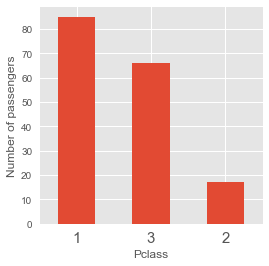

In [22]:
cherbourg = raw_train.query('Embarked == "C"')['Pclass']
with plt.style.context('ggplot'):
    cherbourg.value_counts().plot(kind = 'bar', figsize = (4,4))
    plt.xticks(rotation = 0, fontsize = 15)
    plt.xlabel('Pclass')
    plt.ylabel('Number of passengers')

This confirm our suspicion that higher survival rate at Cherbourg is due to passengers' social class.

Finally, let's examine the interaction between fare, survival rate, and Pclass.

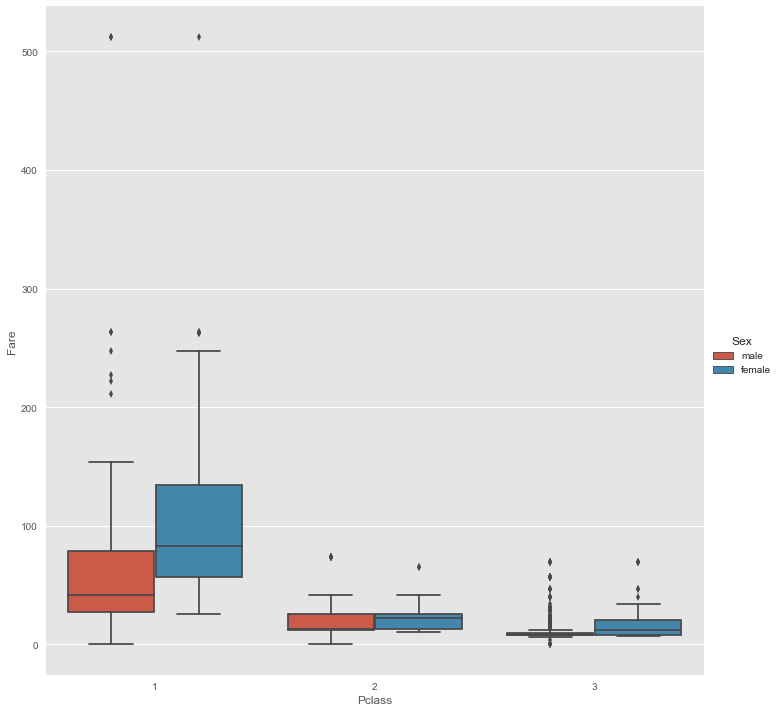

In [23]:
with plt.style.context('ggplot'):
    g = sns.factorplot("Pclass", "Fare", "Sex", data=raw_train, kind="box", size = 10)
    g.set_axis_labels("Pclass", "Fare");

Remove fares above 300 for a clearer picture.

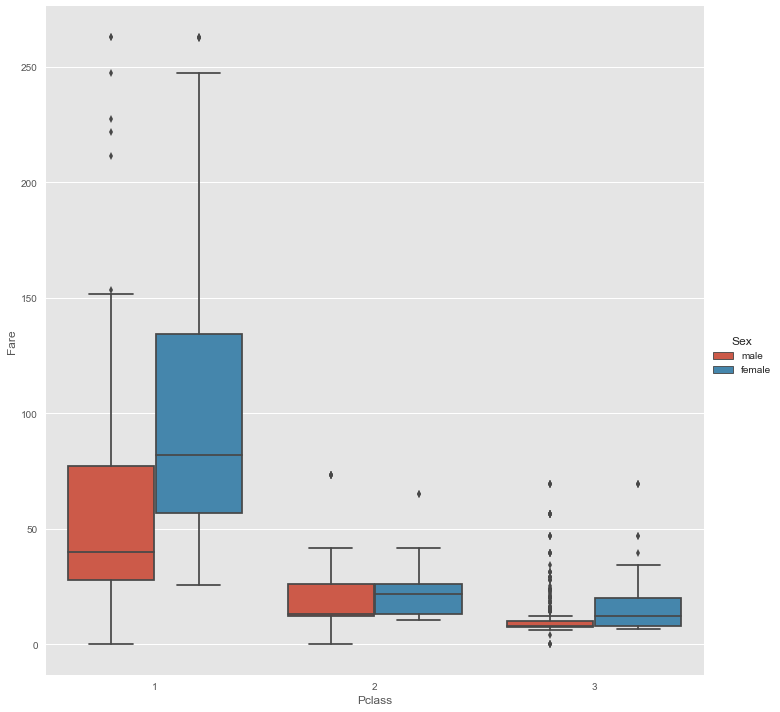

In [24]:
with plt.style.context('ggplot'):
    g = sns.factorplot("Pclass", "Fare", "Sex", data=raw_train.query('Fare < 300'), kind="box", size = 10)
    g.set_axis_labels("Pclass", "Fare");

We see that some first class passengers have paid nothing, and every female must have paid something. Females also paid more on average (especially first class) and generally have a wider spread of prices paid. Let's see the same picture, this time splitting between surived and dead.

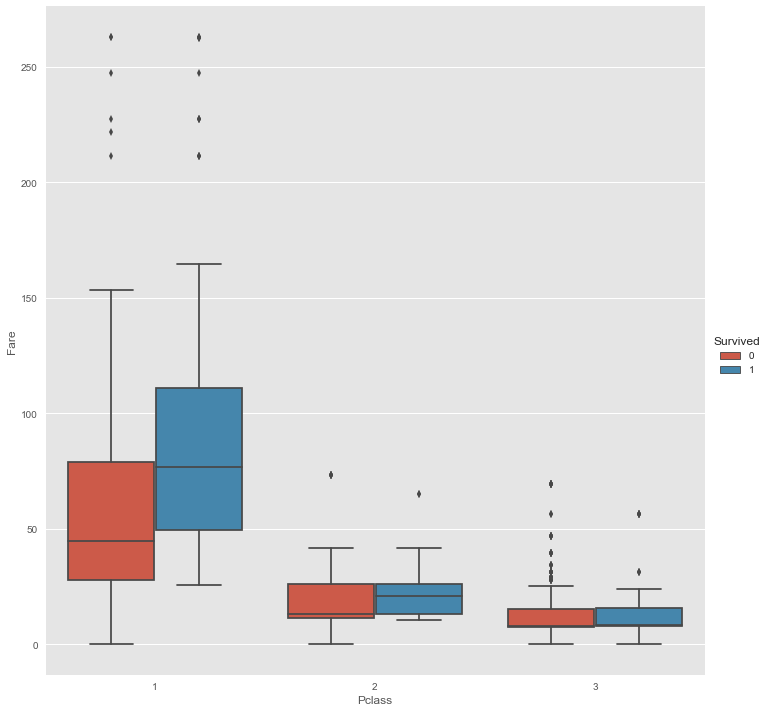

In [25]:
with plt.style.context('ggplot'):
    g = sns.factorplot("Pclass", "Fare", "Survived", data=raw_train.query('Fare < 300'), kind="box", size = 10)
    g.set_axis_labels("Pclass", "Fare");

This looks very similar to the plot above, since women were more likely to survive than men. 

Let us summarise our initial exploration:
* woman are more likely to survive than men
* higher class citizens are more likely to survive
* children and the eldest passengers are more likley to survive
* Fare and Embarked can be seen as indicators of survival probability, but they are correlated with Pclass

## Feature engineering

Since our dataset comprises of relatively few features, we will try and extract more information from them. In this section we will also deal with missing values.

We begin by creating a number of functions for new feature creation and feature engineering.

In [26]:
def FamSize(df):
    '''Adds a Fam(ily)Size column, the sum of siblings, spouses (SibSp), parents and children (Parch). 
     '''
    
    df['FamSize'] = df['SibSp'] + df['Parch']
    return df

In [27]:
def IsAlone(df):
    '''Adds an IsAlone column based on FamSize. Fills it with 1 if FamSize = 0 and 0 otherwise. Returns nothing'''
    
    df['IsAlone'] = (df['FamSize'] == 0).astype('int')
    return df

In [28]:
def SexToInt(df):
    '''Converts sex column to integers.
    Male -> 1
    Female -> 0
     
    '''
    df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    #df['Sex'] = (df.query('Sex == "male"')).astype(int)
    return df

Since Embarked and Pclass are categorical features, we want to one hot encode them.

In [29]:
def OneHot(df, columns = ['Embarked','Pclass']):
    
    '''One hot encodes columns'''
    
    df = pd.get_dummies(df, columns= columns)
    return df

We decided to drop Ticket and Cabin columns, as well as SibSp and Parch which are replaced by FamSize.

In [30]:
def DropUnwanted(df, columns = ['Ticket', 'SibSp','Parch', 'Cabin']):
    '''Drops columns from df'''
    
    df.drop(columns, inplace=True, axis = 1)
    return df

Let's take a closer look at Name column and see what can we extract from it.

In [476]:
sample = np.random.randint(len(raw_train['Name'].unique()), size = 20)
raw_train['Name'].unique()[sample]

array(['Hickman, Mr. Lewis', 'Dantcheff, Mr. Ristiu',
       'Leader, Dr. Alice (Farnham)',
       'Thayer, Mrs. John Borland (Marian Longstreth Morris)',
       'Garfirth, Mr. John', 'de Pelsmaeker, Mr. Alfons',
       'Johnson, Miss. Eleanor Ileen',
       'Cardeza, Mr. Thomas Drake Martinez',
       'Baclini, Miss. Marie Catherine', 'Lulic, Mr. Nikola',
       'Lang, Mr. Fang', 'Lovell, Mr. John Hall ("Henry")',
       'Francatelli, Miss. Laura Mabel', 'Davies, Mr. Charles Henry',
       'Wheadon, Mr. Edward H', 'Sundman, Mr. Johan Julian',
       'Coleff, Mr. Satio', 'Goodwin, Master. Harold Victor',
       'Mangan, Miss. Mary', 'McMahon, Mr. Martin'], dtype=object)

Each name has a title associated with it, and some titles reveal upper social status or marital status of women. Let's extract these titles!

In [509]:
titles = raw_train['Name'].str.extract(r'(\w+\.)')
titles.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Major.         2
Mlle.          2
Countess.      1
Capt.          1
Mme.           1
Lady.          1
Jonkheer.      1
Ms.            1
Don.           1
Sir.           1
Name: Name, dtype: int64

Let's also examine how these titles correlate with survival rate.

In [494]:
pd.concat([titles, raw_train['Survived']], axis=1).groupby('Name').mean().T

Name,Capt.,Col.,Countess.,Don.,Dr.,Jonkheer.,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.
Survived,0.0,0.5,1.0,0.0,0.428571,0.0,1.0,0.5,0.575,0.697802,1.0,1.0,0.156673,0.792,1.0,0.0,1.0


Women as well as some of the less frequent titles seem to be more likely to survive than average. Unsurprisingly, the Captain has sunk with his ship :(

Based on the tables above, we will create a feature for each of the following:
* title Mr
* married women (titles: Mrs and Ms(this one is not quite correct, but there is only one Ms))
* unmarried women (titles: Miss and Mme)
* Master
* other titles (this shouldn't really include captain, but there's only one such person so we'll leave him here, as he won't appear in the test set anyway)

In [34]:
def Title(df):
    '''Extracts titles and maps them into one of 5 categorical features'''
    
    df['Title'] = df['Name'].str.extract(r'(\w+\.)')
    
    titles = ['Don.', 'Rev.', 'Dr.', 'Major.', 'Lady.', 'Sir.', 'Col.', 'Capt.', 'Countees.',' Jonkheer.']

    df['Master'] = df['Title'].apply(lambda x: 1 if x == 'Master.' else 0)
    df['Mr'] = df['Title'].apply(lambda x: 1 if x == 'Mr.' else 0)
    df['Unnmmaried woman'] = df['Title'].apply(lambda x: 1 if x in ['Miss.','Mme.'] else 0)
    df['Married woman'] = df['Title'].apply(lambda x: 1 if x in ['Mrs.','Ms.'] else 0)
    df['Other title'] = df['Title'].apply(lambda x: 1 if x in titles else 0)
    
    df.drop(['Name','Title'], inplace=True, axis = 1)
    return df

Now we will write three functions for imputation of missing data. Recall that training set had missing ages and embark values, while the testing set had missing ages and fares.

In [35]:
def ImputeAge(df):
    ''' Fills missing values of age with the mean for passengers grouped by sex and Pclass'''

    df["Age"] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    return df

In [36]:
def ImputeEmbarked(df):
    '''Fills missing values of Embarked with the mode for passengers grouped by given Pclass'''
    
    df['Embarked'] = df.groupby(['Pclass'])['Embarked'].transform(lambda x: x.mode()[0])    
    return df

In [37]:
def ImputeFare(df):
    '''Fills missing values of Fare with the median for passengers grouped by Sex and Pclass'''
    
    df['Fare'] = df.groupby(['Pclass','Sex']).transform(lambda x: x.fillna(x.median()))
    return df

Finally we split fare into 4 quantiles and one hot encode them.

In [38]:
def FareQuantiles(df):
    '''Cuts columns into 4 quantiles and one hot encode them
    df - data frame
    column - str'''
    
    df['Fare'] = pd.qcut(df['Fare'],4)
    df = pd.get_dummies(df, columns= ['Fare'])
    return df

In [39]:
# Initially we planned on extracting decks from Cabin column. 
# This has actually deteriorated our public LB scores, so we decided to drop Cabin column altogether

# def Decks(df):
#     '''First fill missing values of Cabin with U (unknown). Then extract deck letters from cabin numbers 
#     (eg B38 is cabin 38 on deck B). Finally, one hot encode the decks. Returns nothing'''
    
#     df['Cabin'].fillna('U', inplace = True)
#     df['Deck'] = df['Cabin'].str.extract('([A-Za-z])')
#     df = pd.get_dummies(df, columns= ['Deck'])
    
#     df.drop('Cabin', inplace=True, axis = 1)
#     return df

Having all needed functions in place, we can transform our raw data.

First perform missing data imputation separately on train and test data. This way we avoid information leak from testing set to training set.

In [495]:
ImputeAge(raw_test)
ImputeAge(raw_train)
ImputeEmbarked(raw_train)
ImputeFare(raw_test);

Let's see if our functions worked.

In [496]:
raw_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [497]:
raw_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

As expected, only the cabins are missing at this stage.

For the remainder of the transformations, lets combine the train and test sets and transform them together.

In [510]:
raw_test['Survived'] = np.nan
combined = pd.concat([raw_train,raw_test])

combined = FamSize(combined)
combined = IsAlone(combined)
combined = SexToInt(combined)
combined = OneHot(combined)
combined = FareQuantiles(combined)
combined = Title(combined)
combined = DropUnwanted(combined)

In [499]:
combined.columns

Index(['Age', 'PassengerId', 'Sex', 'Survived', 'FamSize', 'IsAlone',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Fare_[0, 9.5]', 'Fare_(9.5, 30]', 'Fare_(30, 982]',
       'Fare_(982, 1309]', 'Master', 'Mr', 'Unnmmaried woman', 'Married woman',
       'Other title'],
      dtype='object')

Let's split the dataset into train and test again.

In [511]:
Xtrain = combined.iloc[raw_train.index]
Xtrain.drop('PassengerId', inplace = True, axis = 1)
ytrain = Xtrain.pop('Survived')
Xtest = combined.iloc[raw_test.index + len(raw_train.index)]
Xtest.drop('Survived', inplace = True, axis = 1)

In [501]:
Xtrain.head()

,Age,Sex,FamSize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,"Fare_[0, 9.5]","Fare_(9.5, 30]","Fare_(30, 982]","Fare_(982, 1309]",Master,Mr,Unnmmaried woman,Married woman,Other title
0,22.0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0
1,38.0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
2,26.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0
3,35.0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
4,35.0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0


In [502]:
ytrain.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [503]:
Xtest.head()

,Age,PassengerId,Sex,FamSize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,"Fare_[0, 9.5]","Fare_(9.5, 30]","Fare_(30, 982]","Fare_(982, 1309]",Master,Mr,Unnmmaried woman,Married woman,Other title
0,34.5,892,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
1,47.0,893,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
2,62.0,894,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
3,27.0,895,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
4,22.0,896,0,2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Finally, let's examine how family size and travelling alone correlates with survival.

In [504]:
Xtrain.join(ytrain).groupby('FamSize')['Survived'].mean()

FamSize
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

In [505]:
Xtrain.join(ytrain).groupby('IsAlone')['Survived'].mean()

IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

We observe that lone travellers are less likely to survive than people travelling with family, and people with familyy of size 1-3 are most likely to survive. Having a large family makes you even less likely to surive than travelling solo.

## Model selection

In this section we train a number of classification models.

Let's begin by importing necessary sklearn functions.

In [392]:
#import cross validation and grid search tools
from sklearn.model_selection import GridSearchCV

#import classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Initially we planned on using nested cross validation go estimate the performance of our models on previously unseen data. This approach turned out to be too expensive computationally.

In [52]:
# from sklearn.model_selection import StratifiesKfold
#
# def nested_cros_val(clf, p_grid, num_trials = 20, inner_folds = 5, outer_folds = 3):
#     '''
#     Performs a nested cross validation
#     clf - sklearn classifier
#     p_grid - dict, parameter grid
#     num_trials - int, number of times to repeat nested cross validation
#     inner_folds - int, number of inner cv folds
#     outer_folds - int, number of outer cv folds
#     Returns an array of mean scores in each trial
#     '''
#     nested_scores = np.zeros(num_trials)

#     for i in range(num_trials):
      
#         inner_cv = StratifiedKFold(n_splits = inner_folds, shuffle = True, random_state = i)
#         outer_cv = StratifiedKFold(n_splits = outer_folds, shuffle = True, random_state = i)
        
#         grid = GridSearchCV(estimator = clf, param_grid=p_grid, cv = inner_cv.split(Xtrain,ytrain))
    
#         # Nested CV 
#         nested_score = cross_val_score(grid, X=Xtrain, y=ytrain, cv = outer_cv.split(Xtrain,ytrain))
#         nested_scores[i] = nested_score.mean()
    
#     return nested_scores

Let's write a function for finding optimal hyperparameters and fitting the opimtal model to the entire training set.

In [410]:
def tune_and_fit(clf, p_grid, cv = 5, X_train = Xtrain, y_train = ytrain):
    '''Performs grid search over p_grid with cv-fold cross validation.
    Returns the best model found fitted on the entire data set.
    clf - sklearn classifier
    p_grid - dict, parameters grid
    cv - int, number of folds in cross validation
    '''
    
    grid = GridSearchCV(clf, param_grid = p_grid, cv = cv, n_jobs = -1, scoring='accuracy', )
    grid.fit(X_train,y_train)
    print('Best parameters found: ')
    print(grid.best_params_)
    print('\n Best score:')
    print(grid.best_score_)
    
    return grid.best_estimator_

Below is a function which automates generating submission files from our models.

In [411]:
def make_submission(model, filename = 'submission', X_test = Xtest):
    '''Saves passenger id and survival predictions to filename.csv Takes fitted model as input, returns nothing.
    filename - str
    '''
        
    try:
        Xtest.drop('Survived', axis =1, inplace = True)
    except ValueError:
        pass
    
    predictions = model.predict(X_test.drop('PassengerId',axis = 1))
    Xtest['Survived'] = predictions.astype('int')
    Xtest[['PassengerId','Survived']].to_csv('{}.csv'.format(filename), index = False)

Now that we have all function needed for model selection in place, let's use them on a number of standard classifiers.

Let's start by obtaining a baseline via GaussianNB and MultinomialNB (a lot of features take values 0,1 so multinomial NB seems like a good idea).

In [55]:
print('GaussianNB',cross_val_score(GaussianNB(),Xtrain,ytrain,cv = 5).mean())
print('MultinomialNB', cross_val_score(MultinomialNB(),Xtrain,ytrain, cv = 5).mean())

GaussianNB 0.776709659276
MultinomialNB 0.752065528354


### RandomForest

In [56]:
forest_grid = {'max_depth' : [4, 6, 8,10],
                'n_estimators': [10,50,70,100],
                'max_features': ['sqrt', 'auto', 'log2'],
                'min_samples_split': [2, 3, 5, 7, 10],
                'min_samples_leaf': [1,  3, 5, 7, 10],
                'bootstrap': [True, False],
                 }
forest = tune_and_fit(RandomForestClassifier(), forest_grid)

Best parameters found: 
{'bootstrap': True, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}

 Best score:
0.835016835017


In [512]:
make_submission(forest,'submission_forest')

This submission produced a public LB score of 0.79426

### SVC

In [65]:
svc_grid ={'C' : [0.001,0.01,0.1,1,10,100], 'kernel' : ['linear','rbf'],
        'class_weight' : [None,'balanced'], 'shrinking' : [True,False]}

In [66]:
svc = tune_and_fit(SVC(random_state=0), svc_grid)

Best parameters found: 
{'C': 100, 'class_weight': None, 'kernel': 'linear', 'shrinking': True}

 Best score:
0.830527497194


In [513]:
make_submission(svc,'submission_svc')

Public LB score: 0.78469

### MaxEnt

In [68]:
maxent_grid = {'C' : [0.001,0.01,0.1,1,10,100], 'penalty' : ['l1','l2'],
                'class_weight' : [None,'balanced'],}

In [74]:
maxent = tune_and_fit(LogisticRegression(random_state=42), maxent_grid)

Best parameters found: 
{'C': 1, 'class_weight': None, 'penalty': 'l2'}

 Best score:
0.821548821549


In [514]:
make_submission(maxent,'submission_maxent2')

Public LB score: 0.76555

### KNearestNeighbours

In [71]:
knn_grid = {'n_neighbors': np.arange(5,35,1), 'weights': ['uniform', 'distance'], 'p' : [1,2]}

In [72]:
knn = tune_and_fit(KNeighborsClassifier(), knn_grid)

Best parameters found: 
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

 Best score:
0.81593714927


In [515]:
make_submission(knn,'submission_knn')

Public LB score: 0.74641

# Stacking

Let's try improving our score by stacking three best models. We follow approach from http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/ with our stacking function inspired by Esemble class from https://dnc1994.com/2016/05/rank-10-percent-in-first-kaggle-competition-en/ 


In [393]:
from sklearn.model_selection import KFold

In [438]:
def stack_test_set(base_models, col_names):
    '''Takes a list of base_models and a list of strings. 
    Returns a data frame with i-th column (named col_names[i]) consiting of ith base model's predictions 
    of the test set'''
    
    S_test = np.zeros((Xtest.shape[0],len(base_models)))
    
    for i in range(len(base_models)):
        
        base_models[i].fit(Xtrain,ytrain) #make sure models are fitted on the entire training set
        S_test[:,i] = base_models[i].predict(Xtest.drop('PassengerId',axis =1))
    
    return pd.DataFrame(S_test, columns = col_names)        

In [404]:
def stack_training_set(base_models, col_names, n_folds = 5):
    '''Performs stacking of base_models by dividing training data into n_folds and repeating 
    the following procedure n_folds times:
    * train each classifier on n_folds-1 folds, predict on the remaining fold
    * record each classifiers prediction of the remaing fold in a new data frame, keeping the folds indexing
    
    This way we obtain predictions for each base model on the entire training set in a way such that prediction 
    for each point was made by a model which has not seen this particular point in training.
    
    Returns a data frame (num of training examples x number of base columns)
    '''
    
    folds = list(KFold(n_splits = n_folds, shuffle=True, random_state=0).split(Xtrain))
    
    S_train = np.zeros((Xtrain.shape[0], len(base_models)))
    
    for i, clf in enumerate(base_models):
            
        for j, (train_idx, test_idx) in enumerate(folds):
            X_train = Xtrain.iloc[train_idx]
            y_train = ytrain[train_idx]
            X_holdout = Xtrain.iloc[test_idx]
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_holdout)[:]
            S_train[test_idx, i] = y_pred
                                             
    return pd.DataFrame(S_train, columns = col_names)

Let's use our stacking functions to create meta features.

In [439]:
meta_test = stack_test_set([forest,svc,maxent],['forest','svc','maxent'])
meta_train = stack_training_set([forest,svc,maxent], ['forest','svc','maxent'])

Let's also create data frames to hold all features, original + meta.

In [440]:
Strain = pd.concat([Xtrain,meta_train],axis = 1)
Stest = pd.concat([Xtest, meta_test], axis = 1)

In [441]:
Strain.head()

,Age,Sex,FamSize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,...,"Fare_(30, 982]","Fare_(982, 1309]",Master,Mr,Unnmmaried woman,Married woman,Other title,forest,svc,maxent
0,22.0,1,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0.0,0.0,0.0
1,38.0,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,1.0,1.0,1.0
2,26.0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0.0,1.0,1.0
3,35.0,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,1.0,1.0,1.0
4,35.0,1,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0.0,0.0,0.0


For the second 2nd level model, we will first use RandomForest and then xgboost. We will train both models using only meta features first, and then using the original features together with the meta features.

### 2nd level model: RandomForest

Let's first train on meta features only.

In [444]:
stacker_forest1 = tune_and_fit(RandomForestClassifier(random_state=0),forest_grid, cv = 5,X_train = meta_train)

Best parameters found: 
{'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 70}

 Best score:
0.832772166105


In [516]:
make_submission(stacker_forest1, 'submission_stacking_1',pd.concat([Xtest['PassengerId'],meta_test],axis=1))

LB score: 0.78947

Let's repeat the above exercise using both original and meta features.

In [427]:
stacker_forest2 = tune_and_fit(RandomForestClassifier(random_state=0), forest_grid, cv = 5, X_train = Strain)

Best parameters found: 
{'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 50}

 Best score:
0.830527497194


In [517]:
make_submission(stacker_forest2, 'submission_stacking_2',Stest)

This has also produced a LB score of 0.78947

Finally, let's take a look at the graph of feature importances for the above forest.

In [448]:
features = pd.DataFrame()
features['feature'] = Strain.columns
features['importance'] = stacker_forest2.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

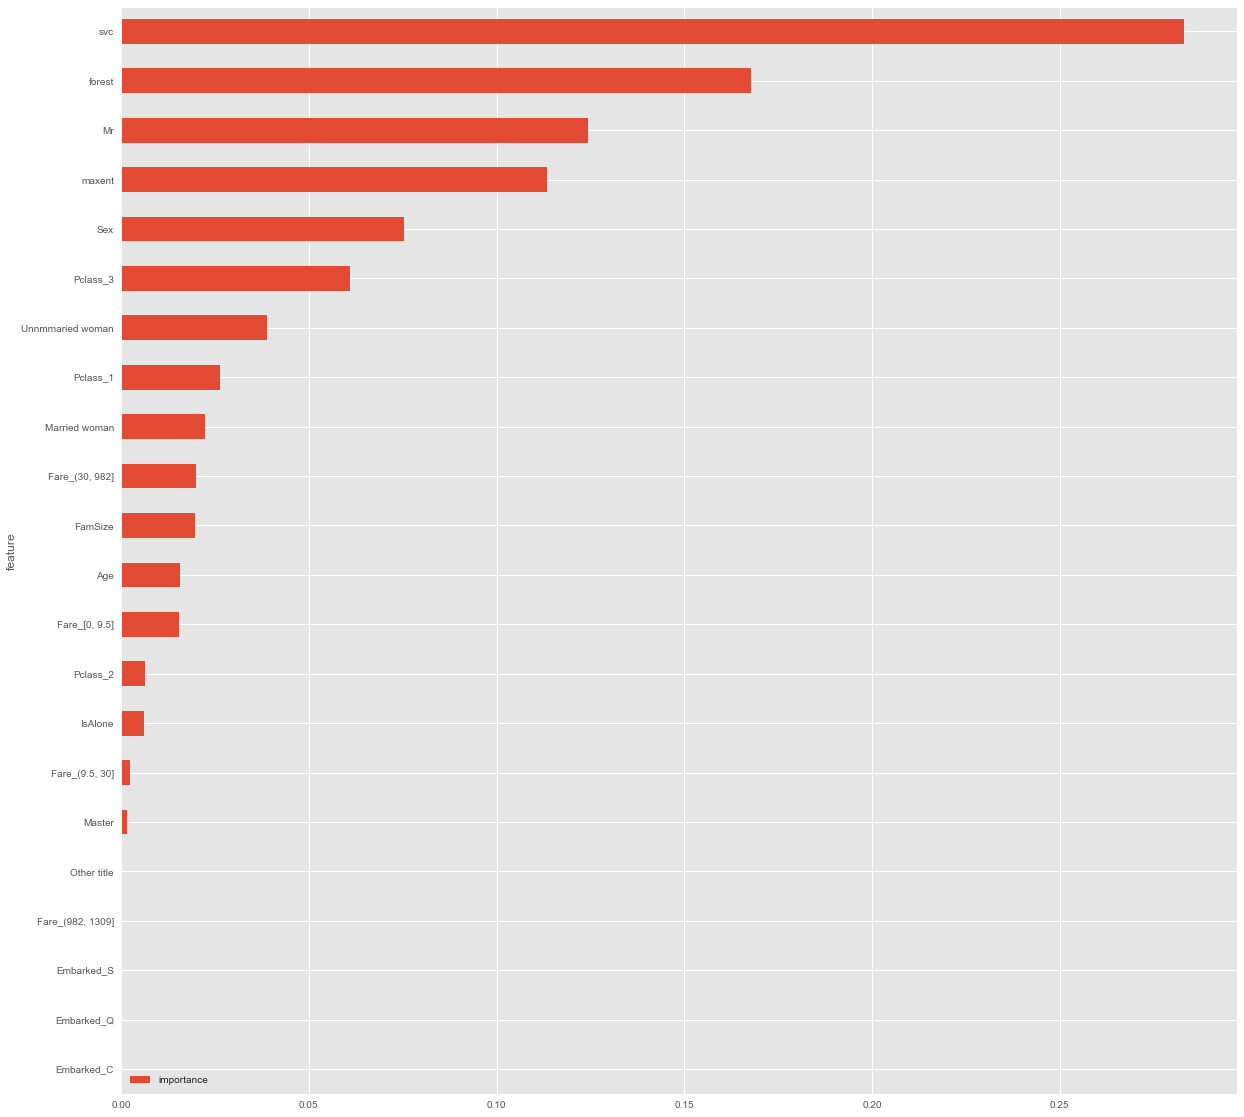

In [449]:
with plt.style.context('ggplot'):
    features.plot(kind='barh', figsize=(20, 20))

We observe that our model really did make use of the base models predictions. I didn't simply repeat the labels of the best model (random forest), as it put more importance on SVC.

### 2nd level model: xgboost

Since using RandomForest as a stacker hasn't yielded any improvement in LB score, let's try xgboost. As earlier, we will use it both on meta features alone and their concatenation with the original features. 

Before we apply xgboost algorithm, we need to rename our Fare features. Xgboost doesn't accept features with commas in their names.

In [450]:
rename_dict = {'Fare_[0, 9.5]' : 'Fare_1', 'Fare_(9.5, 30]' : 'Fare_2', 
               'Fare_(30, 982]': 'Fare_3', 'Fare_(982, 1309]' : 'Fare_4' }

Strain.rename(columns = rename_dict, inplace=True)
Stest.rename(columns = rename_dict, inplace=True)

We will use sklearn wrapper around xgboost.

In [453]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

Define a parameter grid for our boosted tree classifier.

In [454]:
xgb_param_grid = {'max_depth' : np.arange(2,9,1),
                  'subsample' : np.arange(0.3,0.9,0.1),
                  'colsample_bytree' : np.arange(0.4,1,0.1),
                  'gamma' : np.arange(0,1,0.1),
                  'n_estimators' : [50,100,200,300,500]}

Using meta features only.

In [456]:
stacker_xgb1 = tune_and_fit(XGBClassifier(),xgb_param_grid,cv = 5,X_train = meta_train)

Best parameters found: 
{'colsample_bytree': 0.40000000000000002, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.29999999999999999}

 Best score:
0.832772166105


In [518]:
make_submission(stacker_xgb1,'submission_stacking_3',pd.concat([Xtest['PassengerId'],meta_test],axis=1))

LB score: 0.76555

Finally, train xgboost using all features.

In [458]:
stacker_xgb2 = tune_and_fit(XGBClassifier(),xgb_param_grid,cv = 5, X_train = Strain)

Best parameters found: 
{'colsample_bytree': 0.40000000000000002, 'gamma': 0.60000000000000009, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.29999999999999999}

 Best score:
0.842873176207


In [519]:
make_submission(stacker_xgb2, 'submission_stacking_4',Stest)

LB score: 0.77512 

Since this model produced the highest cross validaiton score, but it's final LB score is lower than that of the best base model, it looks like we overfit our xgb.

Let's plot feature importances for the xgboost model.

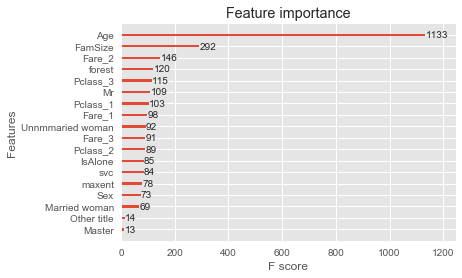

In [460]:
with plt.style.context('ggplot'):
    plot_importance(stacker_xgb2)

Differently than the random forest model, xgboost's main feature was Age. Random Forest base model predictions were 4th most important feature, and SVC and MaxEnt took 13th and 14th place, respectively.

Contrary to our expectations, stacking and using xgboost for 2nd level model did not bear any fruit. Possible explanations:
* not enough base models (just three)
* wrong set of features for 2nd level model (we only tried just meta features or meta features + all, maybe some intermediate subsets of features would work better)
* wrong hyperparameters for xgboost? After all, it performed worse as a stacker than RandomForest (first time ever I used xgboost so my hyperparameter search might be far from optimal)
* Not enough disagreement betweeen base model

To further emphasise our last possible explanation of poor stacking performance, notice:

In [463]:
meta_train['SUM'] = meta_train.eval('forest + svc + maxent')

In [468]:
meta_train.query('SUM != 0 and SUM != 3')['SUM'].count()

69

We note that our three base models disagreed only on 69 passengers (out of 891, that's just under 8%). Perhaps poor performance of our stacking approach was due to the fact that base models were in exact agreement for more than 90% of the data and there just wasn't enough information in our meta features for the 2nd level model to learn from.

### Overall, the best model was a RandomForest with a 5-fold cross validation score of 0.835 and LB score of 0.79426